In [1]:
# import the necessary packages
import os

from scipy.fft import fft2

import numpy as np
from PIL import Image
import cv2

import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

import stitching as st

from IPython.display import clear_output

In [2]:
imagePath = '/home/jack/Videos/map_2_images/'
imageExtension = 'png'
fileTemplateName = 'image'

detectoryType = 'akaze'

images = [imagePath + i for i in os.listdir(imagePath) if imageExtension in i]
imageIndexing = [int(img.split(fileTemplateName)[-1].split('.')[0]) for img in images]

images = np.array(images)[np.argsort(imageIndexing)]

100%|███████████████████████████| 30/30 [00:04<00:00,  6.97it/s]


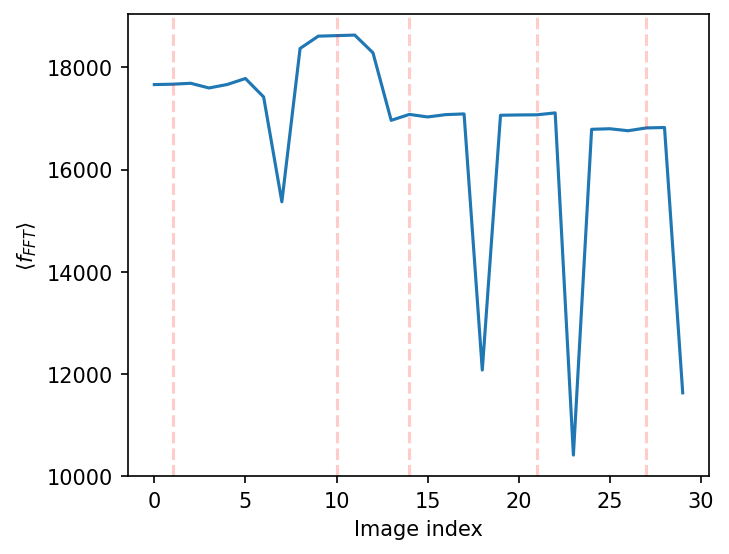

Found 5 stable images


In [3]:
stableImageIndices = st.identifyStableImages(images[:30], derThreshold=.05, debug=True)
print(f'Found {len(stableImageIndices)} stable images')

In [4]:
stitchedOffsets = [[0,0]]
stitchedRotations = [0]

imgArr = [cv2.imread(images[i]) for i in stableImageIndices]

fd = st.FeatureDetector('akaze')
features = [fd.detect_features(np.mean(imgArr[i], axis=-1)) for i in range(len(imgArr))]

for i in tqdm.tqdm(range(len(imgArr)-1)):

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(features[i]["descriptors"], features[i+1]["descriptors"], k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    da = []
    dr = []

    for match in good:
        keypoint1 = features[i]["keypoints"][match.queryIdx]
        keypoint2 = features[i+1]["keypoints"][match.trainIdx]

        dr.append(np.array(keypoint1.pt) - np.array(keypoint2.pt))
        da.append(keypoint1.angle - keypoint2.angle)

    # Fix periodicity
    da = np.where(np.array(da) > 180, np.array(da) - 360, da)
    da = np.where(np.array(da) < -180, np.array(da) + 360, da)

    dr = np.array(dr)
    
    stitchedOffsets.append(np.median(dr, axis=0))
    stitchedRotations.append(np.median(da))
    
stitchedOffsets = np.array(stitchedOffsets)
stitchedRotations = np.array(stitchedRotations)

100%|█████████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


100%|█████████████████████████████| 4/4 [00:02<00:00,  1.53it/s]


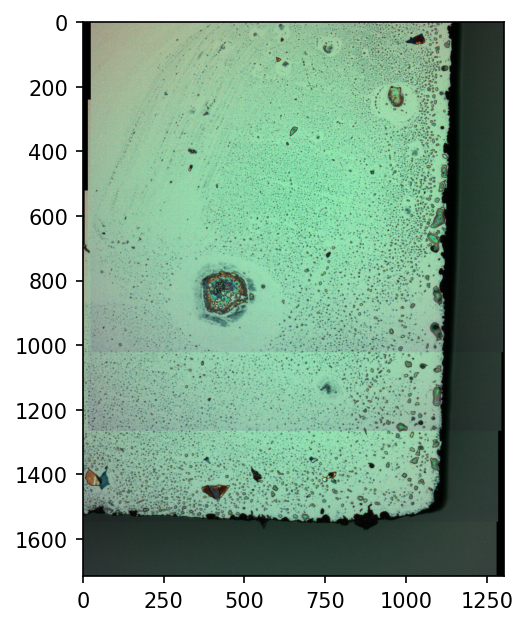

In [6]:
# concat images
approxStitchSize = (5*int(np.abs(np.sum(stitchedOffsets[:,0]))),
                    5*int(np.abs(np.sum(stitchedOffsets[:,0]))))

approxStitchSize = (6000, 6000)

pastedImages = []
corners = []

stitchedImage = Image.new('RGB', approxStitchSize)
currOffset = np.array([4*approxStitchSize[0]/6, 4*approxStitchSize[1]/6])
currRotation = 0

for i in tqdm.tqdm(range(len(imgArr[:4]))):
    currOffset = currOffset + stitchedOffsets[i]
    
    # Grab what the region that is about to be pasted over looks like
    currRegionImg = np.array(stitchedImage.rotate(-currRotation, center=(currOffset[1]+imgArr[i].shape[0]/2, currOffset[0]+imgArr[i].shape[1]/2)), dtype=np.float64)[int(currOffset[1]):int(currOffset[1])+imgArr[i].shape[0],int(currOffset[0]):int(currOffset[0])+imgArr[i].shape[1]]
    currRegionImg[currRegionImg == 0] = np.nan
    
    oldHorizontalGrad = np.array([np.nanmedian(currRegionImg[:,j,:], axis=0) for j in range(currRegionImg.shape[1])])
    oldVerticalGrad = np.array([np.nanmedian(currRegionImg[j,:,:], axis=0) for j in range(currRegionImg.shape[0])])
    
    newHorizontalGrad = np.array([np.median(imgArr[i][:,j,:], axis=0) for j in range(imgArr[i].shape[1])])
    newVerticalGrad = np.array([np.median(imgArr[i][j,:,:], axis=0) for j in range(imgArr[i].shape[0])])

#     plt.plot(oldHorizontalGrad, label='old')
#     plt.plot(newHorizontalGrad, label='new')
#     plt.legend()
#     plt.show()
    
#     plt.plot(oldVerticalGrad, label='old')
#     plt.plot(newVerticalGrad, label='new')
#     plt.legend()
#     plt.show()
    
    #img = np.where(1 - np.isnan(currRegionImg), imgArr[i]*.5 + currRegionImg*.5, imgArr[i])
    #img = st.equalizeSpatialGradients(img, strength=.1)
    img = imgArr[i]
    
    img = Image.fromarray(img.astype(np.uint8))
    img.rotate(currRotation + stitchedRotations[i])

    pastedImages.append(img)
    corners.append((int(currOffset[0]), int(currOffset[1])))
    # plt.imshow(currRegionImg.astype(np.uint8))
    # plt.show()
    
    stitchedImage.paste(img, (int(currOffset[0]), int(currOffset[1])))
    currRotation += stitchedRotations[i]
    
stitchedImage, cropCorner = st.cropToContent(stitchedImage, True)
corners = np.array(corners) - np.array(cropCorner)

plt.imshow(stitchedImage)
plt.show()

In [10]:
Image.fromarray(stitchedImage).save('test_stitch.png')

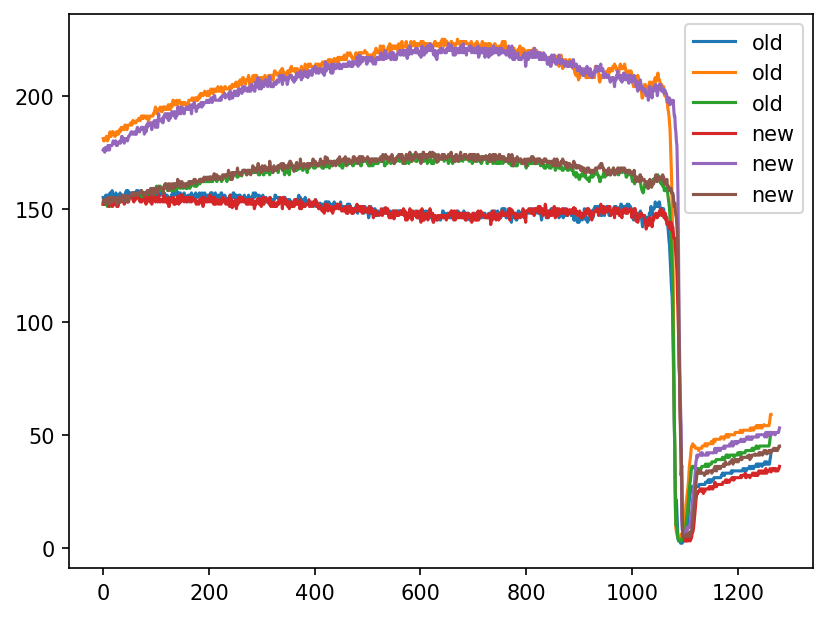

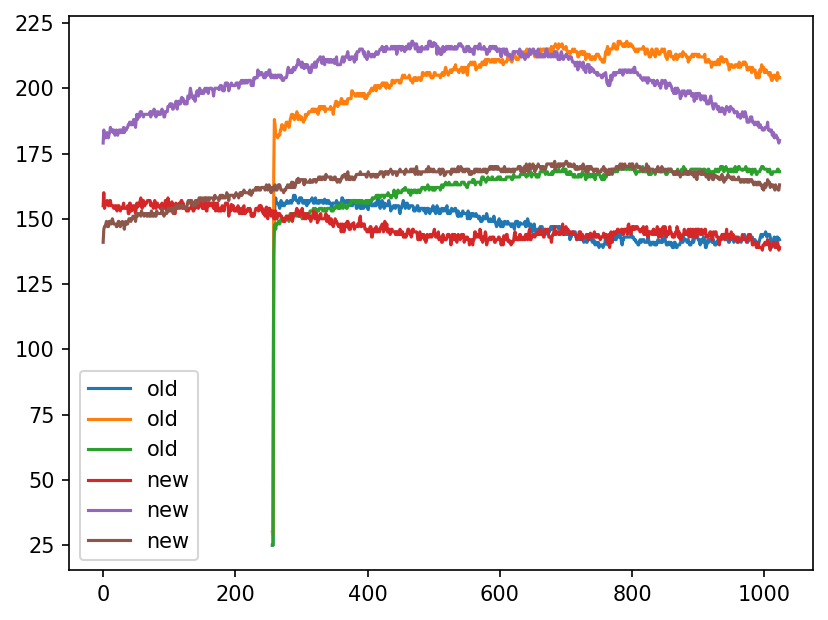

In [11]:
plt.plot(oldHorizontalGrad, label='old')
plt.plot(newHorizontalGrad, label='new')
plt.legend()
plt.show()

plt.plot(oldVerticalGrad, label='old')
plt.plot(newVerticalGrad, label='new')
plt.legend()
plt.show()

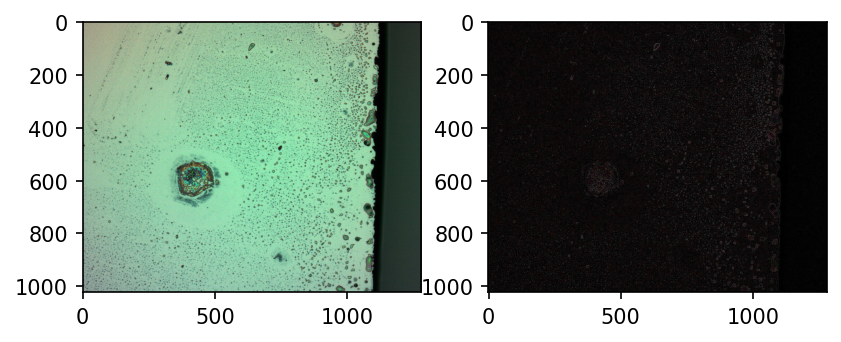

In [8]:
img = np.array(pastedImages[2])

fig, ax = plt.subplots(1, 2)

laplacianKernel = np.array([[0, 1, 0],
                         [1, -4, 1],
                         [0, 1, 0]])

gradImg = cv2.filter2D(img, ddepth=-1, kernel=laplacianKernel)

initialCondition = np.array(stitchedImage)[corners[2][1]+img.shape[0],corners[2][0]:corners[2][0]+img.shape[1]]

ax[0].imshow(img)
ax[1].imshow(gradImg)
plt.show()

In [14]:
corners

array([[  0, 693],
       [  5, 524],
       [ 15, 243],
       [ 24,   0]])

In [13]:
poisson_edit(img, np.array(stitchedImage), np.ones_like(img)[:,:,0], corners[2][::-1])

IndexError: index 1280 is out of bounds for axis 1 with size 1280

In [10]:
"""Poisson image editing.

"""

import numpy as np
import cv2
import scipy.sparse
from scipy.sparse.linalg import spsolve

from os import path

def laplacian_matrix(n, m):
    """Generate the Poisson matrix. 

    Refer to: 
    https://en.wikipedia.org/wiki/Discrete_Poisson_equation

    Note: it's the transpose of the wiki's matrix 
    """
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)
    
    return mat_A


def poisson_edit(source, target, mask, offset):
    """The poisson blending function. 

    Refer to: 
    Perez et. al., "Poisson Image Editing", 2003.
    """

    # Assume: 
    # target is not smaller than source.
    # shape of mask is same as shape of target.
    y_max, x_max = target.shape[:-1]
    y_min, x_min = 0, 0

    x_range = x_max - x_min
    y_range = y_max - y_min
        
    M = np.float32([[1,0,offset[0]],[0,1,offset[1]]])
    source = cv2.warpAffine(source,M,(x_range,y_range))
        
    mask = mask[y_min:y_max, x_min:x_max]    
    mask[mask != 0] = 1
    #mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
    
    mat_A = laplacian_matrix(y_range, x_range)

    # for \Delta g
    laplacian = mat_A.tocsc()

    # set the region outside the mask to identity    
    for y in range(1, y_range - 1):
        for x in range(1, x_range - 1):
            if mask[y, x] == 0:
                k = x + y * x_range
                mat_A[k, k] = 1
                mat_A[k, k + 1] = 0
                mat_A[k, k - 1] = 0
                mat_A[k, k + x_range] = 0
                mat_A[k, k - x_range] = 0

    # corners
    # mask[0, 0]
    # mask[0, y_range-1]
    # mask[x_range-1, 0]
    # mask[x_range-1, y_range-1]

    mat_A = mat_A.tocsc()

    mask_flat = mask.flatten()    
    for channel in range(source.shape[2]):
        source_flat = source[y_min:y_max, x_min:x_max, channel].flatten()
        target_flat = target[y_min:y_max, x_min:x_max, channel].flatten()        

        #concat = source_flat*mask_flat + target_flat*(1-mask_flat)
        
        # inside the mask:
        # \Delta f = div v = \Delta g       
        alpha = 1
        mat_b = laplacian.dot(source_flat)*alpha

        # outside the mask:
        # f = t
        mat_b[mask_flat==0] = target_flat[mask_flat==0]
        
        x = spsolve(mat_A, mat_b)
        #print(x.shape)
        x = x.reshape((y_range, x_range))
        #print(x.shape)
        x[x > 255] = 255
        x[x < 0] = 0
        x = x.astype('uint8')
        #x = cv2.normalize(x, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        #print(x.shape)

        target[y_min:y_max, x_min:x_max, channel] = x

    return target